## XAI eXplainable Artificial Intelligence

## SHAP SHapley Additive exPlanations

* Shapley value와 feature간 독립성을 기초로 머신 러닝 모델의 예측을 설명하는 설명 모델
    - **Shapley Value** : 게임 이론에서 게임 참여자가 협력하여 얻은 이익을 각각에게 공평하게 분배하는 방법을 위한 개념

* feature가 독립적이라는 가정하에, **모델의 예측에 각 feature가 얼마나 기여**하는지를 **feature가 제거되었을 때와 포함되었을 때**의 차이로 계산

<center>Shapley value</center>

$$
\phi_i = \displaystyle\sum_{S \subseteq F/\{i\}} {|S|!\,(|F| - |S| - 1)! \over |F|!} (f(S \cup \{i\}) - f(S))
$$
<center>가중치 X 관심 변수 제외시 기여도</center>

* $\phi_i$ : 특정 변수의 Shapley value
* $S$ : 관심 변수가 제외된 변수 부분집합 ($|S|$ : 집합의 크기)
* $i$ : 관심 있는 변수 집합
* $F$ : 전체 변수의 부분 집합

[공식문서 shap.readthedocs.io](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)

### 0> 데이터 준비

In [3]:
import pandas as pd
from sklearn import datasets

X, Y = datasets.fetch_openml('boston', return_X_y=True, version=1)
X['CHAS'] = X['CHAS'].astype(int) # SHAP에서는 category/str 불가능
X['RAD'] = X['RAD'].astype(int) # SHAP에서는 category/str 불가능
Y = pd.DataFrame(Y, columns=['MEDV'])
df1 = pd.concat([X, Y], axis=1)
df1.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


In [2]:
import numpy as np
import shap

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

shap.initjs() # colab일 경우 모든 셀에 포함시켜야 함.

In [4]:
model_rf = RandomForestRegressor(max_depth=5, n_estimators=20, random_state=42)
model_rf.fit(X, Y.values.ravel())

RandomForestRegressor(max_depth=5, n_estimators=20, random_state=42)

In [5]:
explainer_rf = shap.TreeExplainer(model_rf) # 만약 model_rf.predict 이면 모델을 블랙박스로 간주하고 샘플링 기반 shap 사용
shap_values_rf = explainer_rf(X) # X 모든 데이터에 대해 shap 값 계산

### 1> 폭포형 플롯 shap.waterfall_plot (shap.plots.waterfall)

* 단일 예측에 대한 설명

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
15,0.62739,0.0,8.14,0,0.538,5.834,56.5,4.4986,4,307.0,21.0,395.62,8.47


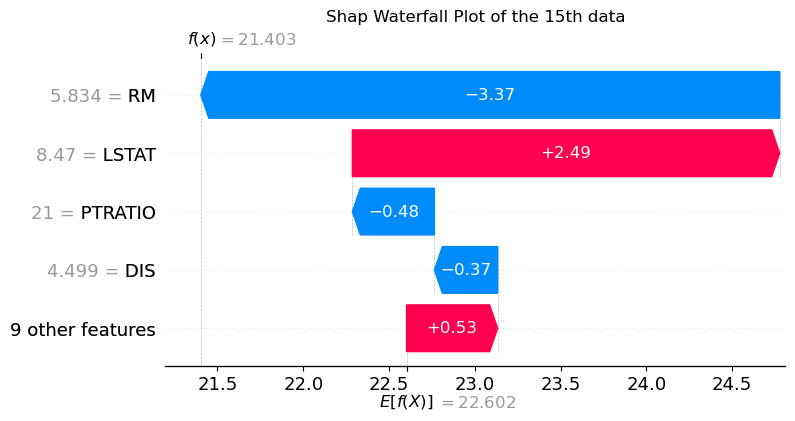

In [74]:
sample_id = 15
display(X.iloc[sample_id : sample_id + 1, :])

plt.title("Shap Waterfall Plot of the %dth data" % (sample_id))
shap.waterfall_plot(shap_values_rf[15], max_display=5)

#### 그래프 해석

In [7]:
print("전체 데이터에 대한 평균 예측값: ", np.round(shap_values_rf[15].base_values, 4))
print("학습된 RF모델이 15번 형태의 입력을 받았을 때 예측할 값: ", np.round(shap_values_rf[15].base_values + sum(shap_values_rf[15].values), 4))
print()

for col in ['RM', 'LSTAT', 'PTRATIO', 'DIS']:
    x_temp = shap_values_rf[15].data[X.columns.get_loc(col)]
    shap_temp = shap_values_rf[15].values[X.columns.get_loc(col)]

    print(f"특성 {col:<7}\t데이터값: {x_temp:6.3f}    예측값에 대한 shap 기여도: {shap_temp:+5.3f}")

전체 데이터에 대한 평균 예측값:  22.6023
학습된 RF모델이 15번 형태의 입력을 받았을 때 예측할 값:  21.4027

특성 RM     	데이터값:  5.834    예측값에 대한 shap 기여도: -3.374
특성 LSTAT  	데이터값:  8.470    예측값에 대한 shap 기여도: +2.491
특성 PTRATIO	데이터값: 21.000    예측값에 대한 shap 기여도: -0.478
특성 DIS    	데이터값:  4.499    예측값에 대한 shap 기여도: -0.368


### 2> 막대 그래프 shap.plots.bar

* 각 특성의 영향력의 절댓값 평균

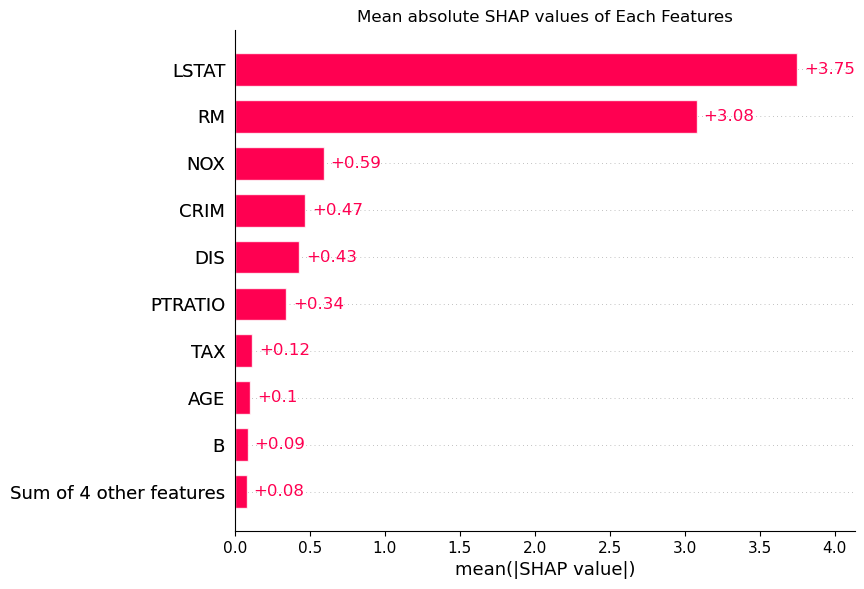

In [39]:
plt.title("Mean absolute SHAP values of Each Features")
shap.plots.bar(shap_values_rf)
# shap.plots.bar(shap_values_rf.abs.max(0)) # 최대 영향을 준 정도

#### 그래프 해석

```python
    np.abs(shap_values_rf.values[:, 12]).sum() / len(X) # LSTAT, np.float64(3.7507)
```

### 3> 의존도 플롯 shap.dependence_plot

* 특정 변수와 가장 교호작용 효과가 큰 변수 확인

#### 교호작용

* 한 요인의 효과가 다른 요인의 수준에 따라 달라지는 현상
* ex) 운동량이 건강에 좋은 영향이 있지만, 나이에 따라 그 효과가 달라지는 경우 -> 운동량 X 나이 교호작용
<br><br>

||<center>상관관계</center>|<center>교호작용</center>|
|-|-|-|
|정의|두 변수 간 선형적 관계&nbsp;&nbsp;|두 변수가 함께 결과에 영향을 주는 방식의 변화&nbsp;|
|수치 표현|상관계수(Pearson 등)|회귀계수, 시각화|

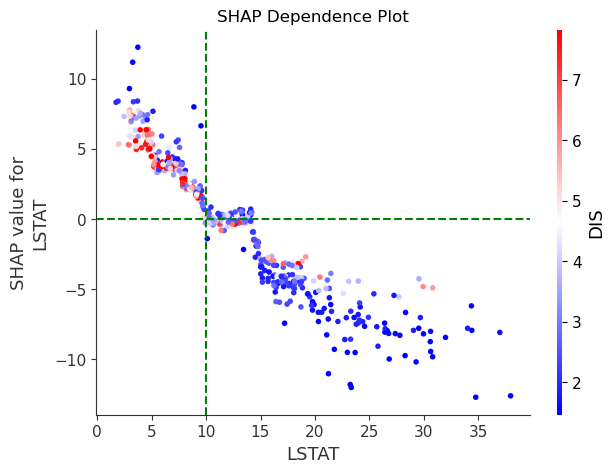

In [53]:
fig = plt.figure(figsize=(7,5))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.dependence_plot('LSTAT', # 인덱스도 가능
                     shap_values_rf.values,
                     X, 
                     feature_names=list(X),
                     ax=ax, # 현재 좌표축
                     cmap='bwr',
                    #  interacion_index='RM') # 명시적으로 지정 가능, 미지정시(='auto') 가장 상호작용 강도가 큰 변수 자동 선택
                     show=False)
ax.axhline(y=0, color='green', linestyle='--')
ax.axvline(x=10,color='green', linestyle='--' )
ax.set_title("SHAP Dependence Plot")
plt.show()

#### shap.dependence_plot 에서 자동으로 교호작용 feature 선택하는 방법

```python
    interaction_index = approximate_interactions(main_feature_index, shap_values, X)[0]
    # main_feature_index=LSTAT -> return 7 (DIS)
```
* 이때 approximate_interactions (list) 는 다음과 같이 계산

1. ```main_feature_index``` 기준으로 데이터와 SHAP 값 정렬
2. 전체 데이터를 최대 50개씩 분할 ```max(min(int(len(X) / 10.0), 50), 1)```
3. 분할된 구간별로 ```abs(corrcoef)``` 계산, 결측치도 포함
4. 모든 feature에 대해 결과값이 가장 큰(상호작용이 강한) feature 선택

[github.com/shap/shap/blob/master/shap/utils/_general.py](https://github.com/shap/shap/blob/master/shap/utils/_general.py#L109)

#### 그래프 해석

* **SHAP value for LSTAT=0** 기준으로, 대략 **LSTAT<=10** 일때 예측값을 증가시키는 방향으로 영향을 미치고 있다.
* 또한 **LSTAT>10** 일 때, 대체로 **DIS**값이 작으며(파란색) 예측값을 감소시키므로 **LSTAT 변수와 DIS 변수 간 교호작용이 있다.**


#### 번외) 선형모델에서의 교호작용과 비교

* 선형모델에서는 LSTAT~DIS 관계가 -0.0207, p=0.342 로 유의하지 않다고 판단함.
* 다만, SHAP에서는 비선형모델(랜덤포레스트)을 사용했기 때문에 당연히 LSTAT과 DIST의 교호작용에 대한 결과가 다름.

In [ ]:
# import statsmodels.api as sm

# tempdf = df1.copy()
# tempdf['X1_X2'] = tempdf['LSTAT'] * tempdf['DIS']
# tempx = sm.add_constant(tempdf.drop('MEDV', axis=1))
# tempy = tempdf['MEDV']
# m2 = sm.OLS(tempy, tempx).fit()

# print(m2.summary())

#                  coef    std err          t      P>|t|      [0.025      0.975]
# ------------------------------------------------------------------------------
# const         36.7250      5.112      7.185      0.000      26.682      46.768
#                                     --- 중략 --- 
# DIS           -1.2525      0.308     -4.071      0.000      -1.857      -0.648
# LSTAT         -0.4720      0.075     -6.281      0.000      -0.620      -0.324
# X1_X2         -0.0207      0.022     -0.952      0.342      -0.063       0.022

### 4> 부분 의존도 플롯 shap.partial_dependence_plot (shap.plots.partial_dependence)

* 특정 특성이 변화했을때 모델의 출력에 어떤 영향을 미치고, 그 특성 값의 분포는 어떻게 되는지

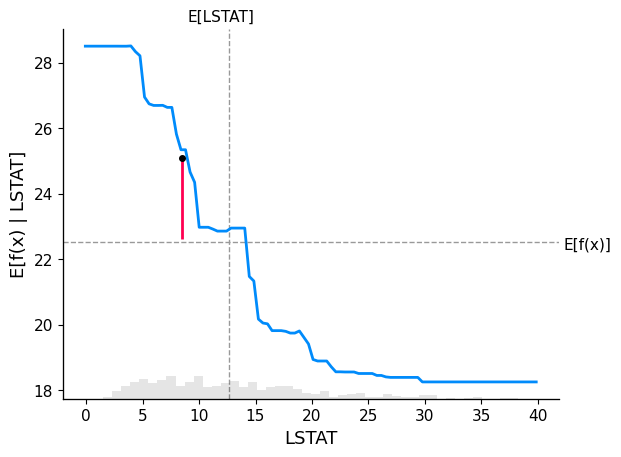

In [81]:
sample_index = 15
shap.partial_dependence_plot(
    'LSTAT',
    model_rf.predict,
    X,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values_rf[sample_index : sample_index + 1, :]
)

#### 그래프 해석

* **수평점선 E[f(x) | LSTAT] = E[f(x)]** : 다른 feature는 고정하고 LSTAT값을 x축값들로 변화시킬 때 모델의 예측값의 평균
```python
        model_rf.predict(X).mean() # 22.5131
```
* **수직점선 LSTAT = E[LSTAT]** : X에서 LSTAT의 평균
```python
        X['LSTAT'].mean() # 12.6530
```
* **빨간선** : 15번 데이터에서, 예측값의 평균에서 영향을 준 LSTAT의 shap value
```python
        shap_values_rf[15, X.columns.get_loc('LSTAT')].values # 2.4905
```
* **검은점** : 모델의 예측값
```python
        model_rf.predict(X).mean() + shap_values_rf[15, X.columns.get_loc('LSTAT')].values # 25.0037
```
* **파란선** : LSTAT 값의 변화에 따른 모델 예측값의 평균의 변화

### 5> 요약 플롯 점 그림 shap.summary_plot(plot_type='dot')

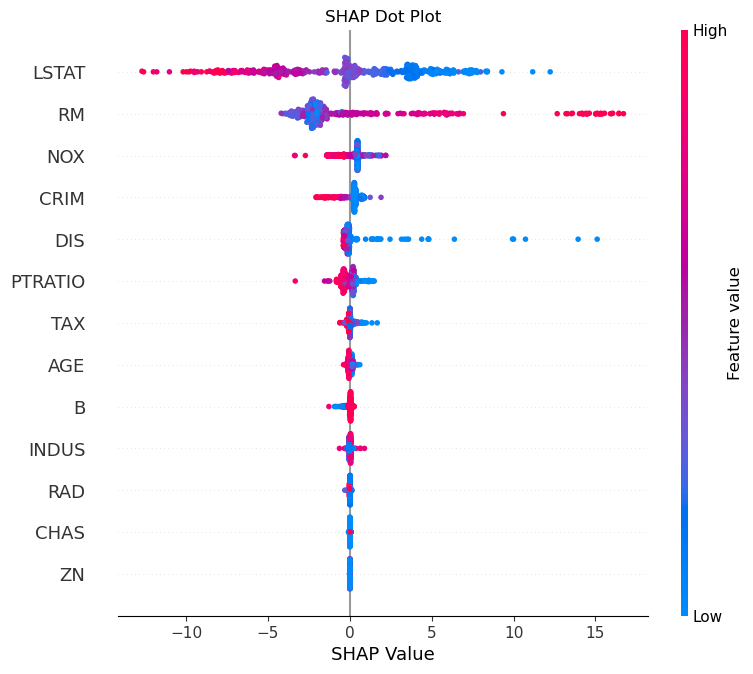

In [13]:
shap.summary_plot(shap_values_rf,
                  X,
                  feature_names=list(X),
                  plot_type='dot',
                  show=False)
plt.title("SHAP Dot Plot")
plt.xlabel("SHAP Value")
plt.show()

#### 그래프 해석

* 빨간색일때 특징이 큰 값, 파란색일때 특징이 작은 값
* 특징이 어떤 값일때 0을 기준으로 어느 방향으로 얼마나 영향을 미치는지 확인
<br><br>
* **LSTAT**은 **큰 값**일수록 **예측값을 크게 감소**시키고, 작은 값일수록 예측값을 크게 증가시킨다. (음의 상관성)
* **RM**은 **작은 값**일수록 **예측값을 약간 감소**시키고, 큰 값일수록 예측값을 크게 증가시킨다. (양의 상관성)

### 6> 힘 플롯 shap.force_plot (shap.plots.force)

* 특정 데이터 하나, 또는 전체 데이터에 대한 SHAP 값 확인

In [ ]:
# sample_id = 15
shap.force_plot(explainer_rf.expected_value,
                shap_values_rf.values[sample_id, :],
                X.iloc[sample_id, :],
                feature_names=list(X))

In [ ]:
shap.save_html("md_img/force_plot1.html",
               shap.force_plot(explainer_rf.expected_value, shap_values_rf.values[sample_id, :], X.iloc[sample_id, :], feature_names=list(X)))

In [7]:
shap.force_plot(explainer_rf.expected_value,
                shap_values_rf.values,
                X)

In [10]:
shap.save_html("md_img/force_plot2.html",
               shap.force_plot(explainer_rf.expected_value, shap_values_rf.values, X))

### 7> XAI 마무리 (FI ~ SHAP)

* SHAP 를 통해 FI 보다 더 나아가서 **변수들이 예측값에 대해 어느 정도의 영향력을 미치는지 정확하게 값으로 확인**할 수 있다.